In [171]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib widget

from pymeasure.instruments.srs import SR830

lockin_pym = SR830('GPIB2::25::INSTR')
lockin_pym.sample_frequency = 256
lockin_pym.write('FAST0')

# SR830 Code samples

## pyvisa

In [172]:
# mant = np.array(list(res_x[0::4])) + np.array(list(res_x[1::4]))*2**8
# mant
# exp = np.array(list(res_x[2::4]))
# exp
# print(lockin.snap())
# mant*np.power(np.ones(shape = exp.shape)*2, exp-124)

In [180]:
import numpy as np
from pyvisa import ResourceManager
from pyvisa.resources import MessageBasedResource
from time import sleep
class SR830Interface:
    def __init__(self, address):
        # Implement your instrument initialization logic here
        # Example: open a connection to the instrument
        self.rm = ResourceManager()
        self.instrument = self.rm.open_resource(address)

    def buffer_stats(self, time):
        xbuf, ybuf = self.buffer_measure(time =time)
        return [np.mean(xbuf), np.std(xbuf)], [np.mean(ybuf), np.std(ybuf)]

    def buffer_measure(self, time):
        self.reset_buffer()
        self.start_buffer()
        sleep(time)
        self.pause_buffer()
        x, y =self.read_buffer_bytes()
        return x, y


    def buffer_bytes_convert(self, buffer):
        mant = np.array(list(buffer[0::4])) + np.array(list(buffer[1::4]))*2**8
        exp = np.array(list(buffer[2::4]))
        return mant*np.power(np.ones(shape = exp.shape)*2, exp-124)

    def read_buffer_bytes(self):
        buffer_size = self.n_buff()
        self.instrument.write(f'TRCL?1, 0, {buffer_size}')
        x_bytes = self.instrument.read_raw()
        self.instrument.write(f'TRCL?2, 0, {buffer_size}')
        y_bytes = self.instrument.read_raw()

        x_buffer, y_buffer = self.buffer_bytes_convert(x_bytes), self.buffer_bytes_convert(y_bytes)
        return x_buffer, y_buffer
    
    def read_buffer_ascii(self):
        buffer_size = self.n_buff()
        x_buffer = self.instrument.query_ascii_values(f"TRCA? 1, 0, {buffer_size}")
        y_buffer = self.instrument.query_ascii_values(f"TRCA? 2, 0, {buffer_size}")
        return x_buffer, y_buffer

    def start_buffer(self):
        self.instrument.write("STRT")

    def pause_buffer(self):
        self.instrument.write("PAUS")

    def reset_buffer(self):
        self.instrument.write("REST")

    def snap(self):
        return self.instrument.query('SNAP? 1,2')
    
    def n_buff(self):
        return float(self.instrument.query('SPTS?'))
lockin = SR830Interface('GPIB2::25::INSTR')
xbuf, ybuf =lockin.buffer_measure(5)



<AxesSubplot:ylabel='Count'>

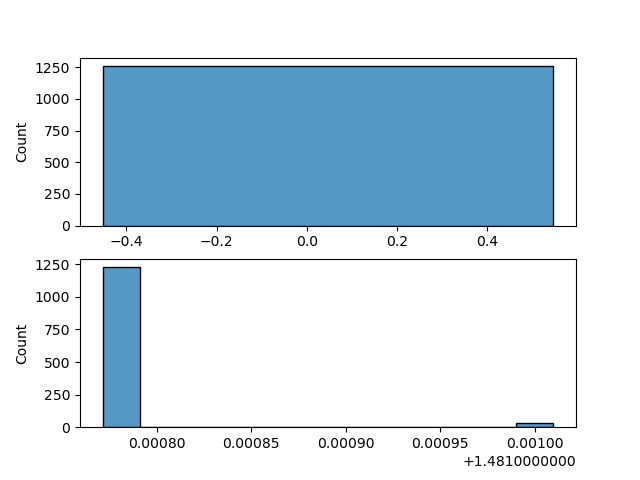

In [181]:
fig, ax = plt.subplots(2,1)

sns.histplot(xbuf*1E3, ax = ax[0])
sns.histplot(ybuf*1E3, ax= ax[1])

## Pymeasure

In [123]:
from pymeasure.instruments.srs import SR830

lockin = SR830('GPIB2::25::INSTR')
lockin.binary_values(f'TRCL?1,0, {lockin.buffer_count}')
lockin.values(f'TRCA?1,0, {lockin.buffer_count}', )
lockin.binary_values(f'TRCL?1,0, {lockin.buffer_count}')
xbuffer, ybuffer = lockin.get_buffer_binary(1), lockin.get_buffer_binary(2)
print(xbuffer.mean(), xbuffer.std())
print(ybuffer.mean(), ybuffer.std())
lockin.binary_values(f'TRCB?1,0,{lockin.buffer_count}')

lockin.write('FAST1')
xbuffer = np.array(lockin.get_buffer_float(channel = 1))
ybuffer = np.array(lockin.get_buffer_float(channel = 2))
print(xbuffer.mean(), xbuffer.std())
print(ybuffer.mean(), ybuffer.std())
print(lockin.SAMPLE_FREQUENCIES)
lockin.time_constant = 0.1
lockin.id
lockin.sample_frequency = 16
print(f'lockin sample freq is={lockin.sample_frequency}')
lockin.reset_buffer()
lockin.start_buffer()
lockin.wait_for_buffer(count = 10*lockin.sample_frequency)
print(lockin.buffer_count)
# xbuffer =lockin.get_buffer_binary(1)
# ybuffer= lockin.get_buffer_binary(2)
# lockin.write(f'TRCB?1,0,{lockin.buffer_count}')
# # lockin.read_binary_values()
# bytes =lockin.read_bytes(count =-1)
# np.frombuffer(bytes[0:], dtype = np.float32)

xbuffer = lockin.get_buffer_float(channel = 1)
ybuffer = lockin.get_buffer_float(channel = 2)
fig, [axa, axb] = plt.subplots(2, 1, tight_layout=True)
axa.hist(xbuffer, edgecolor = 'k')
axb.hist(ybuffer, edgecolor = 'k')
# lockin.write(f'TRCA?1,0,{lockin.buffer_count}')
# # time.sleep(5)
# xbuffer_str = lockin.read()
# xbuffer_str = lockin.ask(f'TRCA?1,0,{lockin.buffer_count}',)
# xbuffer_str

# lockin.write(f'TRCB?1,0,{lockin.buffer_count}')
# # time.sleep(5)
# xbuffer_str = lockin.read_bytes(-1)
# lockin.sample_frequency = 512
# print(f'lockin sample freq is={lockin.sample_frequency}')
# lockin.reset_buffer()
# lockin.start_buffer()
# lockin.wait_for_buffer(count = lockin.sample_frequency*10)
# print(lockin.buffer_count)
# lockin.write(f'TRCA?1,0,{lockin.buffer_count}')
# lockin.read()

In [ ]:
import zhinst.core

In [ ]:
device_id = "dev4934" # Device serial number available on its rear panel.
interface = "1GbE" # For Ethernet connection or when MFLI/MFIA is connected to a remote Data Server.
# interface = "USB" # For all instruments connected to the host computer via USB except MFLI/MFIA.
#interface = "PCIe" # For MFLI/MFIA devices in case the Data Server runs on the device.

# server_host = "localhost"
server_host = '127.0.0.1'
# server_host = "192.168.77.26"
server_port = 8004

#server_port = 8005 # Default port for HF2LI.
api_level = 6 # Maximum API level supported for all instruments except HF2LI.
#api_level = 1 # Maximum API level supported for HF2LI.

# Create an API session to the Data Server.
daq = zhinst.core.ziDAQServer(server_host, server_port, api_level)
# Establish a connection between Data Server and Device.
daq.connectDevice(device_id, interface)

In [ ]:
demod_path = f"/{device_id}/demods/0/"
sample_path = demod_path+'sample'

daq.getSample(sample_path)

{'timestamp': array([227384699796142], dtype=uint64),
 'x': array([-7.57581736e-10]),
 'y': array([7.82990742e-10]),
 'frequency': array([732.9999999]),
 'phase': array([3.37437424]),
 'dio': array([0], dtype=uint32),
 'trigger': array([512], dtype=uint32),
 'auxin0': array([0.00131781]),
 'auxin1': array([0.])}

In [ ]:
daq.setDouble('dev4934/oscs/0/freq', 734)



In [ ]:
'/dev4934/demods/0/sample.R'

'/dev4934/demods/0/sample.R'

In [ ]:
daq.getSample(demod_path+'sample')


{'timestamp': array([227374896695982], dtype=uint64),
 'x': array([1.72026712e-09]),
 'y': array([-1.18313107e-09]),
 'frequency': array([732.9999999]),
 'phase': array([2.07413377]),
 'dio': array([0], dtype=uint32),
 'trigger': array([768], dtype=uint32),
 'auxin0': array([0.00164727]),
 'auxin1': array([-0.00098523])}

In [ ]:
display(daq.listNodes(demod_path))
display(daq.getSample(sample_path))

['/dev4934/demods/0/adcselect',
 '/dev4934/demods/0/order',
 '/dev4934/demods/0/rate',
 '/dev4934/demods/0/oscselect',
 '/dev4934/demods/0/harmonic',
 '/dev4934/demods/0/phaseshift',
 '/dev4934/demods/0/sinc',
 '/dev4934/demods/0/bypass',
 '/dev4934/demods/0/timeconstant',
 '/dev4934/demods/0/enable',
 '/dev4934/demods/0/freq',
 '/dev4934/demods/0/trigger',
 '/dev4934/demods/0/phaseadjust',
 '/dev4934/demods/0/sample']

{'timestamp': array([227375330610862], dtype=uint64),
 'x': array([-6.90321325e-10]),
 'y': array([-1.45805114e-09]),
 'frequency': array([732.9999999]),
 'phase': array([2.03300391]),
 'dio': array([0], dtype=uint32),
 'trigger': array([256], dtype=uint32),
 'auxin0': array([0.00098836]),
 'auxin1': array([-0.00065682])}

In [ ]:
daq.getSample('/dev4934/demods/0/sample')

{'timestamp': array([227375541708462], dtype=uint64),
 'x': array([-5.79671162e-10]),
 'y': array([2.92274571e-09]),
 'frequency': array([732.9999999]),
 'phase': array([1.46130845]),
 'dio': array([0], dtype=uint32),
 'trigger': array([768], dtype=uint32),
 'auxin0': array([0.]),
 'auxin1': array([-0.00164204])}

In [ ]:
# daq.setDouble(f'/{device_id}/sigouts/0/range',12E-3)



In [ ]:
'{:}'.format(3)

'3'

In [ ]:
import datetime as dt
dt.datetime.utcnow().timestamp()

1686521581.199947

# zi_MFLI class

In [ ]:
from importlib import reload
import zurich_MFLI as zur_driver
reload(zur_driver)

daq_obj = zur_driver.zi_MFLI(device_id, interface, server_host, server_port, api_level)

In [ ]:
display(daq_obj.get_XY())
display(daq_obj.get_freq())

[array([7.05867046e-06]), array([2.38378174e-07])]

array([32764.49999994])

In [ ]:
daq_obj.set_freq(32764.51)
daq_obj.get_freq()

array([32764.51000005])